### SiamDecoder Model

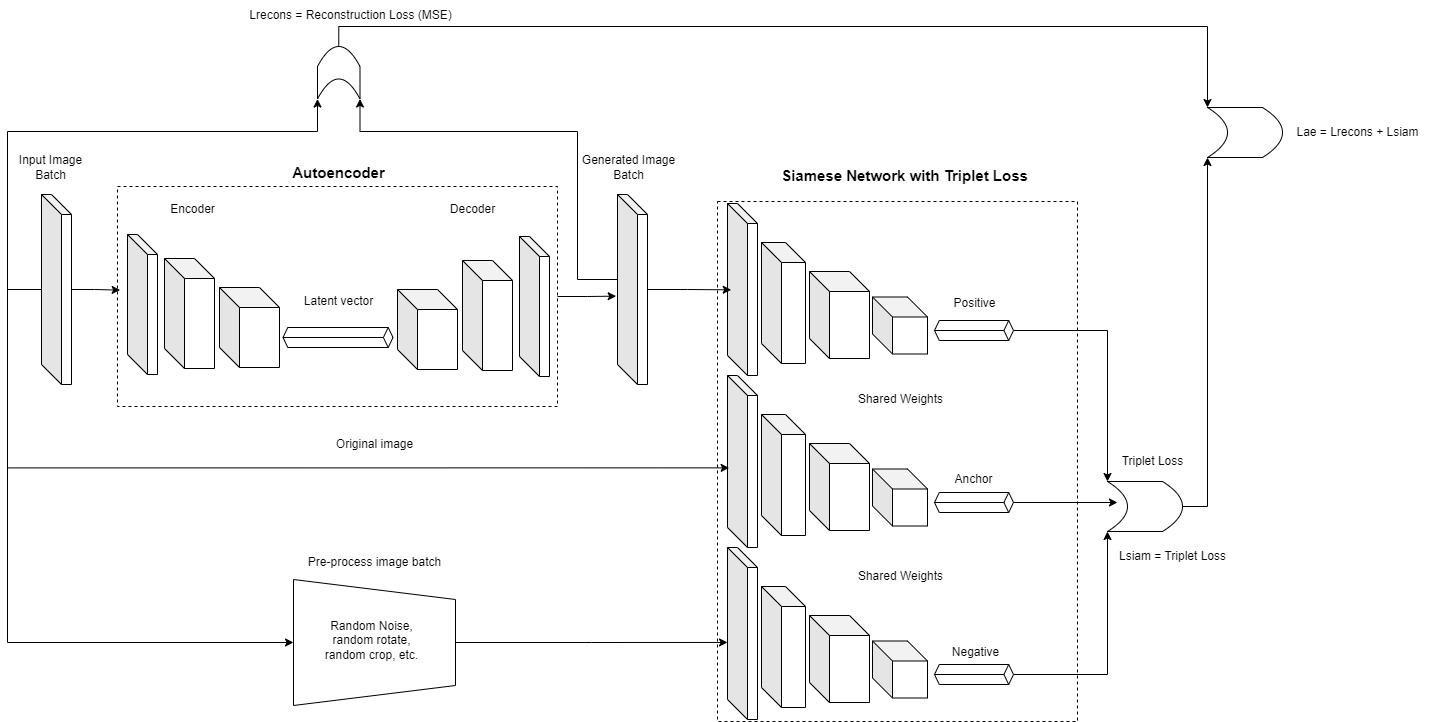

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

Environment Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

os.makedirs('utils/', exist_ok=True)
os.chdir('utils')

! wget https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/models.py
! wget https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/losses.py
! wget https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/vision.py
! wget https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/callbacks.py
! wget https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/utils.py

os.chdir('/content')
print("Current working directory", os.getcwd())

--2023-11-20 07:26:05--  https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/models.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21013 (21K) [text/plain]
Saving to: ‘models.py’

models.py           100%[===================>]  20.52K  --.-KB/s    in 0.001s  

2023-11-20 07:26:05 (31.7 MB/s) - ‘models.py’ saved [21013/21013]

--2023-11-20 07:26:05--  https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/losses.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7280 (7.1K) [text/plain]
Savi

In [ ]:
from utils import vision
from utils import utils
from utils import losses

Environment Setup End

In [ ]:
experiment = {
    'TYPE': 'train',        # Experiment type: 'train', 'test'
    'ACCELERATOR': 'GPU',   # 'CPU', 'GPU' or 'TPU'

    'IMAGE_SIZE': (256, 256),
    'INPUT_SHAPE': (256, 256, 3),
    'VALID_SIZE': 0.1,      # Validation data size: (Valid Data) / (All Data)
    'DATA_AUG': True,       # Apply data augmentation

    'BACKBONE': 'custom',        # 'custom', 'VGG16', 'VGG19' - default 'custom'
    'LAST_TRANIABLE_LAYERS': 5,  # number of last trainable layers of pre-trained backbone models, fine-tuning
    'BATCH_SIZE': 16,            # IF TPU is active set 4, otherwise set anything
    'EPOCHS': 200,
    'OPTIMIZER': 'Adam',  # TODO: Try 'rmsprop' optimizer
    'LEARNING_RATE': 1e-4,

    'RECONS_LOSS': 'PERCEPTUAL',  # Reconstruction loss ('SSIM', 'MSE', 'MAE', 'PERCEPTUAL')
    'PERCEPTUAL_LAYERS': [5,8,13,18],    # [5,8,13,18], None
    'PERCEP_LOSS_MODEL': 'VGG19', # custom', 'VGG16', 'VGG19' - default 'VGG16'
    'PERP_LOSS_LAMBDA': 1,
    'LRELU_SLOPE': 0.2,       # Leaky ReLU activation function slope value
    'MSE_LOSS_LAMBDA': 0.01,  # MSE coeff

    # set the dimensionality of the latent space to a plane for visualization later
    'LATENT_DIM': 500,

    'SAVE_WEIGHTS_PER_EPOCH': 10,
    # Record directory of model's trained weights
    'TRAINING_WEIGHT_DIR': "siam_decoder_resnet50_model/BD67_dataset/training_weights",
    # Record directory of generated images
    'IMGS_DIR': "siam_decoder_resnet50_model/BD67_dataset/images",
}

In [ ]:
ROOT_PATH = '/content'
DATASET_PATH = '/content/drive/MyDrive/MASTER/Master_Thesis/Dataset/BD67_Dataset'
TFRECORD_TRAIN_PATH = '/content/drive/MyDrive/MASTER/Master_Thesis/Dataset/BD67_TFRecord/images.tfrecords'
TFRECORD_TEST_PATH = '/content/drive/MyDrive/MASTER/Master_Thesis/Dataset/BD67_TFRecord/images_test.tfrecords'
BD67_NORMAL_PATH = os.path.join(DATASET_PATH, 'defect_free')
BD67_NORMAL_FRONT_PATH = os.path.join(DATASET_PATH, 'defect_free/Front/cropped')
BD67_NORMAL_FRONT_ROTATED_PATH = os.path.join(DATASET_PATH, 'defect_free/Front/rotated_images/cropped')
BD67_NORMAL_REAR_PATH = os.path.join(DATASET_PATH, 'defect_free/Rear')
BD67_DEFECTED_FRONT_PATH = os.path.join(DATASET_PATH, 'defected/Front/cropped')
BD67_DEFECTED_REAR_PATH = os.path.join(DATASET_PATH, 'defected/Rear')
REFERENCE_BD67_NORMAL_FRONT = os.path.join(DATASET_PATH, 'defect_free/Front/reference_img')

In [ ]:
img_files = utils.get_image_file_list(BD67_NORMAL_FRONT_PATH, 'png')
rotated_img_files = utils.get_image_file_list(BD67_NORMAL_FRONT_ROTATED_PATH, 'png')
all_img_files = img_files + rotated_img_files
reference_img_file = utils.get_image_file_list(REFERENCE_BD67_NORMAL_FRONT, 'png')

print("Number of flat image files: ", len(img_files))
print("Number of rotated image files: ", len(rotated_img_files))
print("Number of all image files: ", len(all_img_files))
print("Number of reference image files: ", len(reference_img_file))

Number of flat image files:  110
Number of rotated image files:  105
Number of all image files:  215
Number of reference image files:  1


### Data Augmentation Layer

In [ ]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal_and_vertical"), # randomly flip images on horizontal/vertical edge
  preprocessing.RandomRotation(0.2), # randomly rotate images by a specific amount
  preprocessing.RandomZoom(0.2), # randomly zoom into an image
  tf.keras.layers.RandomBrightness(factor=0.2, value_range=[0.0, 1.0], seed=None),
  # value_range parameter should be [0.0, 1.0] for RandomBrightness
  # if images were scaled before, default value is [0,255]
  #tf.keras.layers.RandomContrast(0.2, seed=None),
  #tf.keras.layers.RandomCrop(256, 256, seed=None), Error - Image size changes
  #preprocessing.RandomWidth(0.2), # randomly adjust the width of an image by a specific amount
  #preprocessing.RandomHeight(0.2), # randomly adjust the height of an image by a specific amount
  #preprocessing.Rescaling(1./255) # keep for models like ResNet50V2, remove for EfficientNet
], name="data_augmentation")

In [ ]:
def apply_augmentation(image):
    image = data_augmentation(image, training=True)  # Apply data augmentation layers
    return image

In [ ]:
sample_image = utils.load_images(all_img_files[0], img_size=experiment['IMAGE_SIZE'], scl=True)

Random Cutout Image

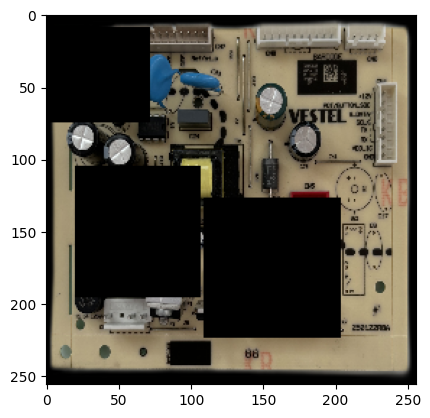

In [ ]:
image_cutout = utils.random_cutout_image(sample_image, min_mask_edge=50, max_mask_edge=100, num_cuts=3)
plt.imshow(image_cutout)

Add Blur to image

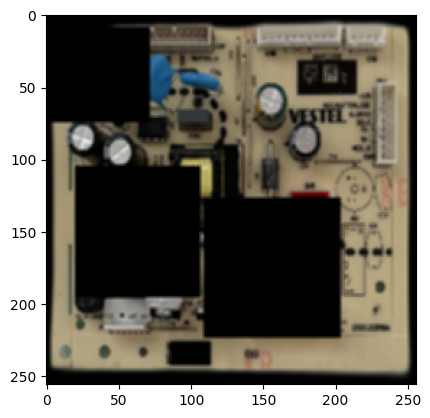

In [ ]:
blurred_image = utils.apply_blur(image_cutout)
plt.imshow(blurred_image)

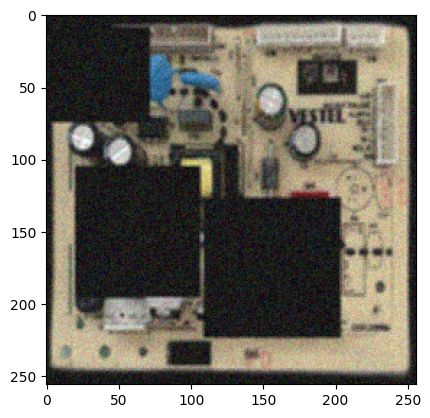

In [ ]:
distorted_image = utils.apply_distortion(blurred_image, distortion_factor=0.2)
plt.imshow(distorted_image)

In [ ]:
def _generate_negative_image(image):
  #image = utils.random_cutout_image(image, min_mask_edge=50, max_mask_edge=100, num_cuts=3)
  #image = tf.image.random_flip_left_right(image, seed=42)
  image = tf.image.random_contrast(image, lower=0.2, upper=1.8, seed=42)
  image = tf.image.random_brightness(image, max_delta=0.2, seed=42)
  image = utils.apply_blur(image)
  image = utils.apply_distortion(image, distortion_factor=0.2)
  image = tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)
  return image

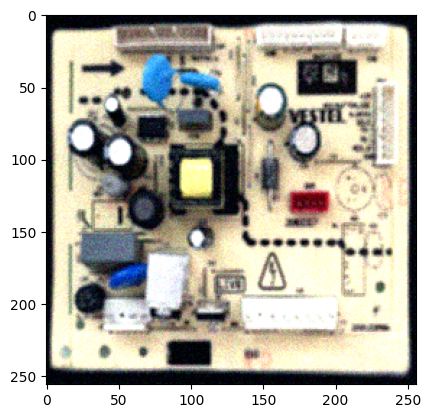

In [ ]:
negative_img = utils.load_images(all_img_files[0], img_size=experiment['IMAGE_SIZE'], scl=True)
negative_img = _generate_negative_image(negative_img)
plt.imshow(negative_img)

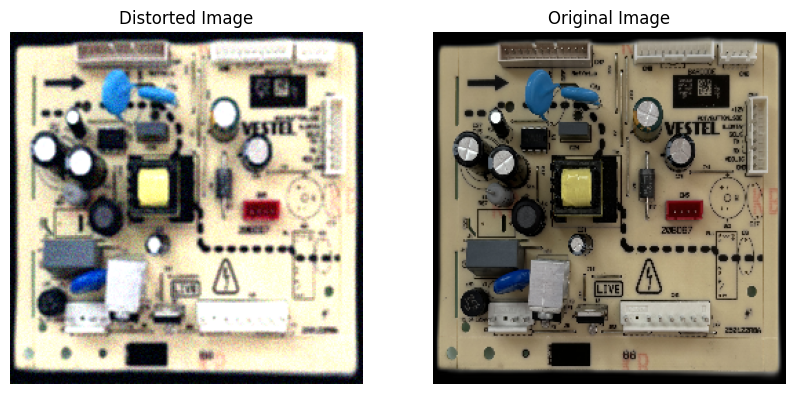

In [ ]:
plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
plt.imshow(negative_img)
plt.title("Distorted Image")
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(sample_image)
plt.title("Original Image")
plt.axis('off')
plt.show()

In [ ]:
# Load and preprocess the three images given the corresponding filenames
def generate_negative_image(img_file):
    # Load the specified file as a JPEG image and preprocess it
    return _generate_negative_image(utils.load_images(img_file, img_size=experiment['IMAGE_SIZE'], scl=True))

In [ ]:
negative_img_ds = np.array(list(map(generate_negative_image, all_img_files)))

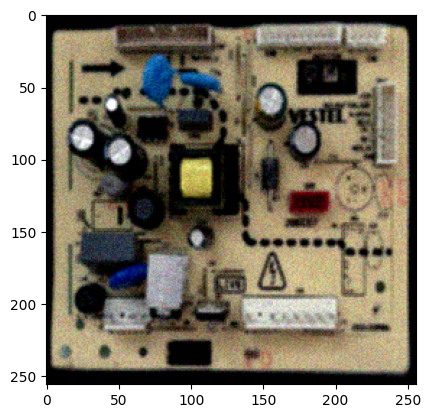

In [ ]:
plt.imshow(negative_img_ds[0])

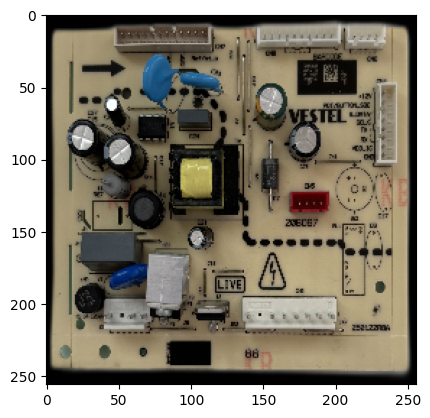

In [ ]:
anchor_imgs_ds = utils.load_and_prepare_images(all_img_files, img_size=experiment['IMAGE_SIZE'], scl=True)
plt.imshow(anchor_imgs_ds[0])

In [ ]:
negative_dataset = tf.data.Dataset.from_tensor_slices(negative_img_ds)
del negative_img_ds  # free memory
anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_imgs_ds)
del anchor_imgs_ds  # free memory

In [ ]:
dataset_input = tf.data.Dataset.zip((anchor_dataset, negative_dataset))
del anchor_dataset # free memory
del negative_dataset # free memory

In [ ]:
print("Total Image Count: ", len(all_img_files))

Total Image Count:  215


In [ ]:
image_count = len(all_img_files)
STEPS_PER_EPOCH = round(image_count * (1-experiment['VALID_SIZE'])) // experiment['BATCH_SIZE']
VALID_STEPS_PER_EPOCH = round(image_count * (experiment['VALID_SIZE'])) // experiment['BATCH_SIZE']
print("Number of images: ", image_count)
print("Steps per epoch: ", STEPS_PER_EPOCH)
print("Valid steps per epoch: ", VALID_STEPS_PER_EPOCH)

Number of images:  215
Steps per epoch:  12
Valid steps per epoch:  1


Create Dataset pipeline

In [ ]:
train_dataset = dataset_input.take(round(image_count * (1-experiment['VALID_SIZE']))).batch(experiment['BATCH_SIZE'], drop_remainder=False).prefetch(tf.data.experimental.AUTOTUNE)
valid_dataset = dataset_input.skip(round(image_count * (1-experiment['VALID_SIZE']))).batch(experiment['BATCH_SIZE'], drop_remainder=False).prefetch(tf.data.experimental.AUTOTUNE)
del dataset_input

In [ ]:
print("Train dataset size: ", len(train_dataset))
print("Valid dataset size: ", len(valid_dataset))

Train dataset size:  13
Valid dataset size:  2


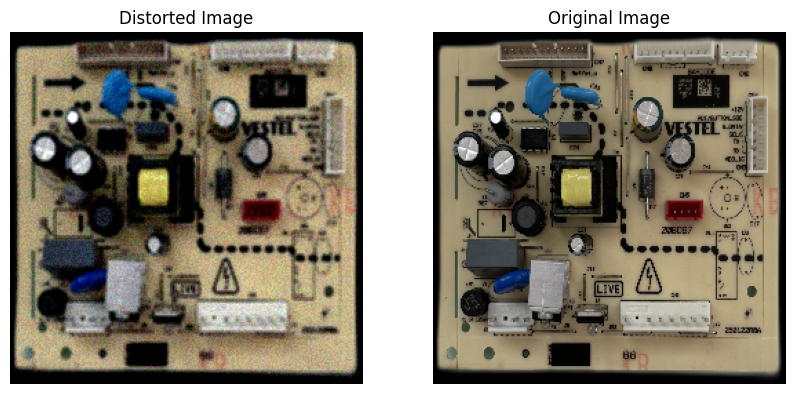

In [ ]:
anchor_img_batch, negative_img_batch = next(iter(train_dataset))

plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
plt.imshow(negative_img_batch[0])
plt.title("Distorted Image")
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(anchor_img_batch[0])
plt.title("Original Image")
plt.axis('off')
plt.show()

In [ ]:
class SiamDecoderResNet50Model(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """
    def __init__(self, input_shape, latent_dim, layer_sizes=None, margin=0.5, mse_lambda=0.5):
        super(SiamDecoderResNet50Model, self).__init__()
        self._input_shape = input_shape
        self._latent_dim = latent_dim
        self._margin = margin
        self._mse_lambda = mse_lambda
        self._layer_iter = 0
        self._layer_sizes = [32, 64, 128, 128, 256, 256, 256]
        if layer_sizes != None:
          self._layer_sizes = layer_sizes
        num_strides = len(self._layer_sizes)
        self._num_dense = int(self._input_shape[0]/(2**num_strides))

        self.config_conv_blocks()
        self._conv_ae_model = self.build_conv_autoencoder()
        self._siamese_resnet50_network = self.build_resnet50_siam_network()
        self._ae_loss_tracker = tf.keras.metrics.Mean(name="ae_loss")
        self._mse_loss_tracker = tf.keras.metrics.Mean(name="mse_loss")
        self._siam_loss_tracker = tf.keras.metrics.Mean(name="siam_loss")

    def call(self, inputs):
        return self._conv_ae_model(inputs, training=False)

    def compile(self, ae_optimizer, siam_optimizer):
        super(SiamDecoderResNet50Model, self).compile()
        self.ae_optimizer = ae_optimizer
        self.siam_optimizer = siam_optimizer

    def config_conv_blocks(self, padding='same', use_bias=True, batch_norm=True, use_leaky_relu=True, leaky_slope=0.2):
        self.padding = padding
        self.use_bias = use_bias
        self.batch_norm = batch_norm
        self.leaky_slope = leaky_slope
        self.act_func = tf.keras.layers.LeakyReLU(self.leaky_slope) if use_leaky_relu else tf.keras.layers.ReLU()

    def conv_block(self, x, filters, kernel, stride, deconv=False, name='conv_block'):
        if deconv:
          x = tf.keras.layers.Conv2DTranspose(filters=filters, kernel_size=(kernel,kernel), strides=stride, padding=self.padding, use_bias=self.use_bias, name=name)(x)
        else:
          x = tf.keras.layers.Conv2D(filters=filters, kernel_size=(kernel,kernel), strides=stride, padding=self.padding, use_bias=self.use_bias, name=name)(x)

        if self.batch_norm:
          name = 'conv_block_bacth_norm_' + str(self._layer_iter)
          x = keras.layers.BatchNormalization(name=name)(x)

        self._layer_iter += 1
        x = self.act_func(x)
        return x

    def summary(self):
        return self._siamese_resnet50_network.summary()

    def build_conv_autoencoder(self):
        # Encoder Part
        input = keras.Input(shape=self._input_shape)
        # Conv blocks
        x = self.conv_block(input, filters=self._layer_sizes[0], kernel=5, stride=2, name='conv2d_block_0')
        for ix, num_filter in enumerate(self._layer_sizes[1:]):
          _name = 'conv2d_block_' + str((ix+1))
          x = self.conv_block(x, filters=num_filter, kernel=5, stride=2, name=_name)
        # Flatten layer
        x = keras.layers.Flatten(name='flatten_layer')(x)
        x = Dense(units=(self._num_dense*self._num_dense*256))(x)

        #x = BatchNormalization(name='bacth_norm_1')(x)
        x = keras.layers.LeakyReLU(alpha=self.leaky_slope)(x)
        # Latent vector
        x = Dense(units=self._latent_dim, name='latent_layer')(x)
        x = keras.layers.LeakyReLU(alpha=self.leaky_slope)(x)

        # Decoder Part
        x = Dense(units=(self._num_dense*self._num_dense*256))(x)
        #x = BatchNormalization(name='batch_norm_2')(x)
        x = keras.layers.LeakyReLU(alpha=self.leaky_slope)(x)

        x = tf.keras.layers.Reshape((self._num_dense,self._num_dense,256), name='reshape_latent')(x)

        # Set activation func to ReLu for Conv2dTrasnpose blocks
        self.config_conv_blocks(use_leaky_relu=False)
        for ix, num_filter in enumerate(self._layer_sizes[-2::-1]):  # Reverse layer_sizes list and remove first element of the reversed array
          _name = 'conv2d_transpose_block_' + str((ix+1))
          x = self.conv_block(x, num_filter, kernel=5, stride=2, deconv=True, name=_name)

        output = keras.layers.Conv2DTranspose(filters=self._input_shape[2], kernel_size=5, strides=2, padding='same',
        use_bias=True, activation='sigmoid')(x)

        return keras.models.Model(input, output, name="conv_ae_model")

    def build_resnet50_siam_network(self):
        resnet50_model = tf.keras.applications.resnet.ResNet50(weights='imagenet', input_shape=self._input_shape, include_top=False)
        # input_shape: optional shape tuple, only to be specified if include_top is False
        # (otherwise the input shape has to be (224, 224, 3).  It should have exactly 3
        # inputs channels, and width and height should be no smaller than 32.
        # E.g. (200, 200, 3) would be one valid value.

        trainable = False
        for layer in resnet50_model.layers:
          if layer.name == 'conv5_block1_out':
            trainable = True
          layer.trainable = trainable

        flatten = keras.layers.Flatten()(resnet50_model.output)
        dense1 = keras.layers.Dense(512, activation="relu")(flatten)
        dense1 = keras.layers.BatchNormalization()(dense1)
        dense2 = keras.layers.Dense(256, activation="relu")(dense1)
        dense2 = keras.layers.BatchNormalization()(dense2)
        output = keras.layers.Dense(256)(dense2)

        return tf.keras.Model(resnet50_model.input, output, name="siamese_resnet50_model")

    def train_step(self, data):
        anchor, negative = data  # positive images will be generated by autoencoder

        anchor_input = tf.keras.applications.resnet.preprocess_input(anchor)
        negative_input = tf.keras.applications.resnet.preprocess_input(negative)

        with tf.GradientTape() as ae_tape, tf.GradientTape() as siam_tape:
            positive = self._conv_ae_model(anchor, training=True)
            positive_input = tf.keras.applications.resnet.preprocess_input(positive)

            anchor_features = self._siamese_resnet50_network(anchor_input, training=True)
            positive_features = self._siamese_resnet50_network(positive_input, training=True)
            negative_features = self._siamese_resnet50_network(negative_input, training=True)

            siam_loss = self.compute_triplet_loss(anchor_features, positive_features, negative_features)
            mse_loss = self.compute_mse_loss(anchor, positive)
            ae_loss = self._mse_lambda*tf.reduce_sum(mse_loss) + (1.0-self._mse_lambda)*siam_loss

        # List of variables to be included in backpropagation
        gradients_ae = ae_tape.gradient(ae_loss, self._conv_ae_model.trainable_weights)
        gradients_siam = siam_tape.gradient(siam_loss, self._siamese_resnet50_network.trainable_weights)
        self.ae_optimizer.apply_gradients(zip(gradients_ae, self._conv_ae_model.trainable_weights))
        self.siam_optimizer.apply_gradients(zip(gradients_siam, self._siamese_resnet50_network.trainable_weights))

        # Let's update and return the training loss metric.
        self._ae_loss_tracker.update_state(ae_loss)
        self._siam_loss_tracker.update_state(siam_loss)
        self._mse_loss_tracker.update_state(mse_loss)
        return {"ae_loss": self._ae_loss_tracker.result(), "mse_loss": self._mse_loss_tracker.result(), "siam_loss": self._siam_loss_tracker.result()}

    def test_step(self, data):
        anchor, negative = data
        generated_data = self._conv_ae_model(anchor, training=False)
        loss = self.compute_mse_loss(data, generated_data)

        # Let's update and return the loss metric.
        self._ae_loss_tracker.update_state(loss)
        return {"ae_loss": self._ae_loss_tracker.result()}

    # Triplet Loss: L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    # In Distance Layer: ap_distance = ‖f(A) - f(P)‖², an_distance = ‖f(A) - f(N)‖²
    def compute_triplet_loss(self, anchor_features, positive_features, negative_features):
        ap_distance = tf.reduce_sum(tf.square(anchor_features - positive_features), -1)
        an_distance = tf.reduce_sum(tf.square(anchor_features - negative_features), -1)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self._margin, 0.0)
        return loss

    def compute_mse_loss(self, anchor_features, positive_features):
        return keras.losses.mean_squared_error(anchor_features, positive_features)

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self._ae_loss_tracker, self._siam_loss_tracker, self._mse_loss_tracker]

In [ ]:
siamese_resnet50_model = SiamDecoderResNet50Model(input_shape=experiment['INPUT_SHAPE'], latent_dim=experiment['LATENT_DIM'])
#siamese_resnet50_model.summary()

In [ ]:
#siamese_resnet50_model._conv_ae_model.summary()

In [ ]:
siamese_resnet50_model.compile(ae_optimizer=tf.keras.optimizers.Adam(0.0003), siam_optimizer=tf.keras.optimizers.Adam(0.0003))
siamese_resnet50_model.fit(train_dataset, epochs=experiment['EPOCHS'], validation_data=valid_dataset)

Epoch 1/200
13/13 [==============================] - 31s 454ms/step - ae_loss: 36272.9648 - mse_loss: 0.0696 - siam_loss: 77.6904 - val_ae_loss: 0.0726
Epoch 2/200
13/13 [==============================] - 6s 425ms/step - ae_loss: 24007.0977 - mse_loss: 0.0461 - siam_loss: 39.6579 - val_ae_loss: 0.0695
Epoch 3/200
13/13 [==============================] - 6s 433ms/step - ae_loss: 18378.1348 - mse_loss: 0.0353 - siam_loss: 7.8235 - val_ae_loss: 0.0653
Epoch 4/200
13/13 [==============================] - 6s 431ms/step - ae_loss: 16158.8965 - mse_loss: 0.0311 - siam_loss: 4.8011 - val_ae_loss: 0.0599
Epoch 5/200
13/13 [==============================] - 6s 433ms/step - ae_loss: 15151.4844 - mse_loss: 0.0292 - siam_loss: 2.8940 - val_ae_loss: 0.0548
Epoch 6/200
13/13 [==============================] - 6s 433ms/step - ae_loss: 14458.2930 - mse_loss: 0.0278 - siam_loss: 1.0023 - val_ae_loss: 0.0522
Epoch 7/200
13/13 [==============================] - 6s 434ms/step - ae_loss: 14032.0400 - mse_lo

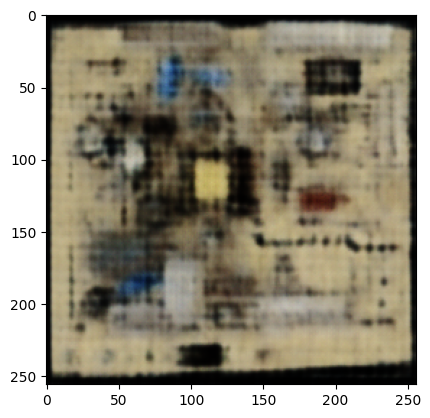

In [ ]:
anchor_batch, negative_batch = next(iter(valid_dataset))

generated_img_batch = siamese_resnet50_model(anchor_batch)
plt.imshow(generated_img_batch[0])

In [ ]:
os.makedirs(experiment['TRAINING_WEIGHT_DIR'], exist_ok=True)
os.makedirs(experiment['IMGS_DIR'], exist_ok=True)

In [ ]:
siamese_resnet50_model.save_weights(experiment['TRAINING_WEIGHT_DIR'] + '/siam_decoder_resnet50_model_bd67_ds_epochs_'+ str(experiment['EPOCHS'])+'.h5')

In [ ]:
import shutil

if experiment['TYPE'] == 'train':
  shutil.copy('/content/siam_decoder_resnet50_model/BD67_dataset/training_weights/siam_decoder_resnet50_model_bd67_ds_epochs_200.h5', '/content/drive/MyDrive/MASTER/Master_Thesis/Dataset/Chekpoints/siam_decoder_resnet50_model/experiment_1')

We should expect the similarity between the anchor and positive images to be larger than the similarity between the anchor and the negative images.

In [ ]:
cosine_similarity = tf.keras.metrics.CosineSimilarity()

similarity = cosine_similarity(anchor_batch[0], generated_img_batch[0])
print("Similarity:", similarity.numpy())

Similarity: 0.93680143
